In [5]:
import os
import librosa
from librosa.display import specshow
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import random
import seaborn
import scipy, IPython.display as ipd
import pickle as pkl
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from datetime import datetime
import glob
def debug(str):
    if debug_flag:
        print(str)
import warnings
warnings.filterwarnings('ignore')

### Setting seed for reproducibility
random_state = 7
np.random.seed(random_state)
torch.manual_seed(random_state)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [7]:
folder_loc = '/beegfs/bva212/fma_small'
files = glob.glob(folder_loc+'/*/*.mp3')
print('Total files: {0}'.format(len(files)))

Total files: 8000


In [8]:
cqt_folder_loc = '/beegfs/bva212/fma_small_cqt'
cqt_files = glob.glob(cqt_folder_loc+'/*/*.npy')
print('Total CQT files: {0}'.format(len(cqt_files)))

Total CQT files: 7838


In [13]:
waveform, fs = librosa.load(files[5], sr=22050)

/home/sc6957/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


In [14]:
x=np.flip(waveform)
x=np.ascontiguousarray(x, dtype=np.float32)

In [15]:
ipd.Audio(x, rate=fs)

In [16]:
ipd.Audio(waveform, rate=fs)

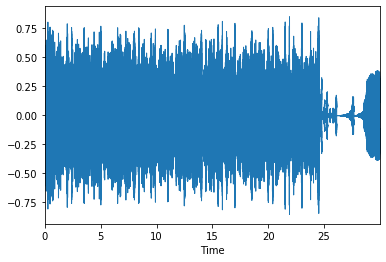

In [17]:
librosa.display.waveplot(x, sr=fs)

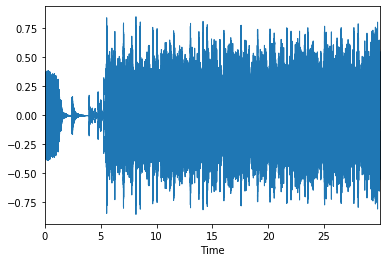

In [18]:
librosa.display.waveplot(waveform, sr=fs)

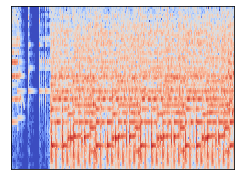

In [19]:
cqt = librosa.cqt(waveform)
logscalogram = librosa.amplitude_to_db(np.abs(cqt))
height, width = logscalogram.shape
specshow(logscalogram)
plt.gcf().set_size_inches(4, 3)

(84, 1291)
3
84
(84, 420)


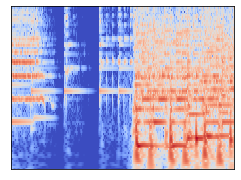

In [20]:
cqt = librosa.cqt(waveform)
logscalogram = librosa.amplitude_to_db(np.abs(cqt))

print(logscalogram.shape)
height, width = logscalogram.shape

new_width = 420

specshow(logscalogram[:,:new_width])
plt.gcf().set_size_inches(4, 3)

splitgrams = [logscalogram[:,:new_width],logscalogram[:,new_width+10:2*new_width+10],logscalogram[:,2*new_width+20:3*new_width+20]]

print(len(splitgrams))
print(len(splitgrams[0]))
print(splitgrams[2].shape)

In [21]:
def perm_generator(length,target):
  original_perm = np.array(list(range(length)))
  result = []
  result.append(original_perm)
  while(len(result)!=target):
    perm = np.random.permutation(list(range(length)))
   # print('Generated')
    flag=1
    for r in result:
      if (perm==r).all() == True:
        flag=0
    if flag:
      #print('added')
      result.append(perm)
    else:
      pass
      #print('rejected')
  return result

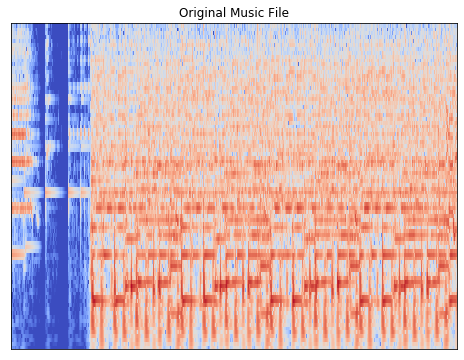

13


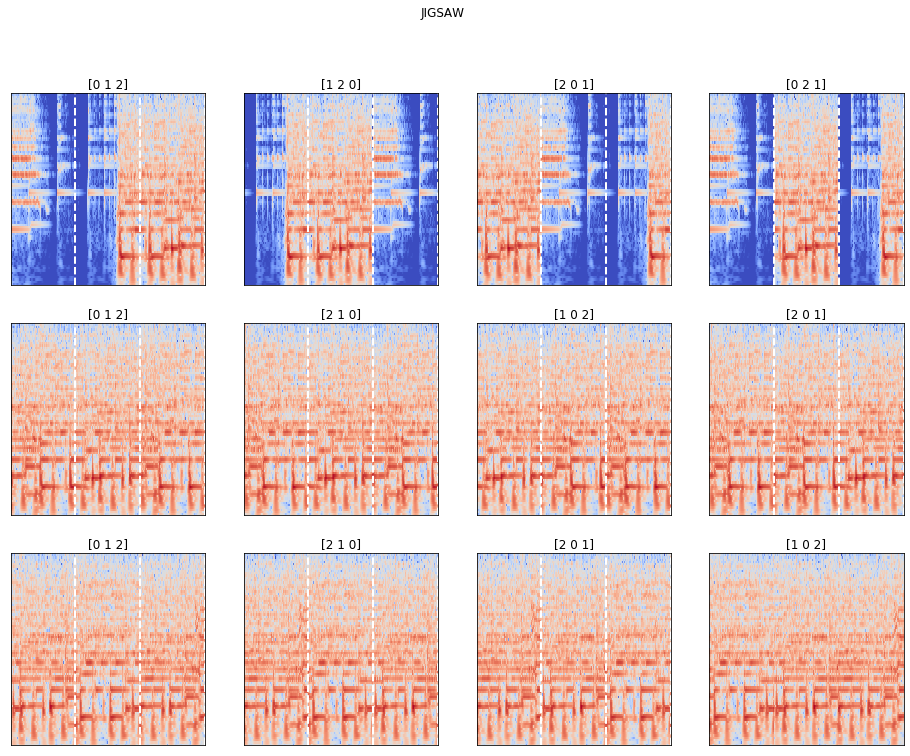

In [22]:
plt.figure(figsize=(8,6))
specshow(logscalogram)
plt.title('Original Music File')
plt.show()

plt.figure(figsize=(16,12))
ind=1
for specgram in splitgrams:
  X = []
  Y = []
  jigsaw_nested = [np.split(specgram, 3, axis=1)][0]
  while len(X) != 4:
    perms = perm_generator(3,4)
    for perm in perms:
      jigsaw_stacked = np.concatenate([jigsaw_nested[x] for x in perm],axis=1)
      X.append(jigsaw_stacked)
  Y = np.ones(4)
  Y[0]=0
  for x,y in zip(X,perms):
    jigsaw_xs = (new_width * np.array([1, 2, 3]) / 3).astype('int')
    for jigsaw_x in jigsaw_xs:
      plt.plot(
          [jigsaw_x, jigsaw_x], [0, height],
          '--', color='w', linewidth=2.0)
    
    plt.subplot(3,4,ind)
    specshow(x)
    #plt.gcf().set_size_inches(4, 3)
    plt.title(str(y))
    
    ind+=1
print(ind) 
plt.suptitle('JIGSAW')
plt.show()

In [23]:
def generate_jigsaw(waveform):
  cqt = librosa.cqt(waveform)
  logscalogram = librosa.amplitude_to_db(np.abs(cqt))
  new_width = 420
  splitgrams = [logscalogram[:,:new_width],logscalogram[:,new_width+10:2*new_width+10],logscalogram[:,2*new_width+20:3*new_width+20]]
  X = []
  Y = []
  for specgram in splitgrams:
    cnt = 0
    jigsaw_nested = [np.split(specgram, 3, axis=1)][0]
    while cnt != 4:
      perms = perm_generator(3,4)
      for perm in perms:
        jigsaw_stacked = np.concatenate([jigsaw_nested[x] for x in perm],axis=1)
        X.append(jigsaw_stacked)
        if cnt == 0:
          Y.append(1)
        else:
          Y.append(0)
        cnt += 1

  return X,Y

X,Y = generate_jigsaw(waveform)
  

In [24]:
Y

[1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]

In [25]:
permutation_mappings = [
    ([0,1,2],[1,0,0,0,0,0],0),
    ([0,2,1],[0,1,0,0,0,0],1),
    ([1,0,2],[0,0,1,0,0,0],2),
    ([1,2,0],[0,0,0,1,0,0],3),
    ([2,0,1],[0,0,0,0,1,0],4),
    ([2,1,0],[0,0,0,0,0,1],5)
]

In [26]:
def data_generator(files,mode):
  file = np.random.choice(files)
  exclude_files = ['098/098567.mp3_cqt.npy', '098/098565.mp3_cqt.npy', '098/098569.mp3_cqt.npy']
  waveform, fs = librosa.load(file, sr=22050)
  cqt = librosa.cqt(waveform)
  logscalogram = librosa.amplitude_to_db(np.abs(cqt))
  #print(logscalogram.shape)
  splitgrams = [logscalogram[:,:new_width],logscalogram[:,new_width+10:2*new_width+10],logscalogram[:,2*new_width+20:3*new_width+20]]
  #print(len(splitgrams))
  #print(splitgrams[0].shape)
  chosen_split = splitgrams[np.random.choice([0,1,2])]
  #print(chosen_split.shape)
  if mode=='jigsaw':
    jigsaw_splits = [np.split(chosen_split, 3, axis=1)][0] ## [0] is to flatten the array. [1] does not have any element
    #print(len(jigsaw_splits))
    #print(jigsaw_splits[0].shape)  
    chosen_perm = permutation_mappings[np.random.choice([0,1,2,3,4,5])]
    Y = chosen_perm[2]
    X = np.array([jigsaw_splits[x][:,:-5] for x in chosen_perm[0]]) ## Trimming last 5 pixels to avoid common borders
  elif mode=='flip':
    coin_flip = np.random.random()
    if coin_flip>0.5:
      X = np.flip(chosen_split,axis=1)
      Y = 1
    else:
      X = chosen_split
      Y = 0
    X = np.ascontiguousarray(X, dtype=np.float32)
  else:
    X = chosen_split
    Y = 0
    specshow(x)
  #print(X.shape)
  yield X,Y

In [27]:
%time X,Y=next(data_generator(files,mode='jigsaw'))

/home/sc6957/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


CPU times: user 1.64 s, sys: 34.4 ms, total: 1.67 s
Wall time: 1.95 s


In [28]:
X[2].shape

(84, 135)

In [29]:
BATCH_SIZE=32
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [30]:
print(datetime.now())
batch_x = []
batch_y = []

while(len(batch_x)!=BATCH_SIZE):
  x,y = next(data_generator(files,mode='jigsaw'))
  batch_x.append(x)
  batch_y.append(y)
  #print(y)
  #specshow(x)

batch_x = torch.from_numpy(np.array(batch_x))
batch_y = torch.from_numpy(np.array(batch_y))
print(datetime.now())

2019-10-16 02:55:25.662488


/home/sc6957/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/sc6957/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/sc6957/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/sc6957/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/sc6957/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread i

2019-10-16 02:56:26.314661


In [31]:
batch_x.shape

torch.Size([32, 3, 84, 135])

In [32]:
batch_y.shape

torch.Size([32])

In [33]:
def create_batches(files,n,BATCH_SIZE):
  batches_x = []
  batches_y = []
  while(len(batches_x)!=n):
    batch_x = []
    batch_y = []
    while(len(batch_x)!=BATCH_SIZE):
      x,y = next(data_generator(files,mode='jigsaw'))
      batch_x.append(x)
      batch_y.append(y)
      #print(y)
      #specshow(x)
    batches_x.append(np.array(batch_x))
    batches_y.append(np.array(batch_y))

  batches_x = torch.from_numpy(np.array(batches_x))
  batches_y = torch.from_numpy(np.array(batches_y))
  return batches_x,batches_y
print(datetime.now())

2019-10-16 02:56:26.346428


In [49]:
folder_loc = '/beegfs/bva212/fma_small'
files = glob.glob(folder_loc+'/*/*.mp3')
length=len(files)
train_ratio,val_ratio,test_ratio=.8,.1,.1
np.random.shuffle(files)
train_files= files[:int(length*train_ratio)]
val_files=files[int(length*train_ratio):int(length*train_ratio)+int(length*val_ratio)]
test_files=files[int(length*train_ratio)+int(length*val_ratio):]
print('Total files: {0}\nTrain files: {1} Ratio: {4:.2f}\nVal files: {2} Ratio: {5:.2f}\nTest files: {3} Ratio: {6:.2f}'.format(length,len(train_files),len(val_files),len(test_files),len(train_files)/length,len(val_files)/length,len(test_files)/length))

Total files: 8000
Train files: 6400 Ratio: 0.80
Val files: 800 Ratio: 0.10
Test files: 800 Ratio: 0.10


In [35]:
print(datetime.now())
batch_size=2
no_batches=1
train_data = create_batches(train_files,no_batches,batch_size)
val_data = create_batches(val_files,no_batches,batch_size)
test_data = create_batches(test_files,no_batches,batch_size)
print(datetime.now())

2019-10-16 02:56:26.461558


/home/sc6957/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/sc6957/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/sc6957/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/sc6957/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/sc6957/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread i

2019-10-16 02:56:37.050714


In [36]:
train_data[1].shape

torch.Size([1, 2])

In [37]:
class PrepareData(Dataset):

    def __init__(self, files):
        self.files = files
        
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        X,Y = next(data_generator(self.files,mode='jigsaw'))
#         if not torch.is_tensor(X):
#             self.X = torch.from_numpy(X)
#         if not torch.is_tensor(y):
#             self.y = torch.from_numpy(y)
        return X,Y


In [45]:
# def loadModel(path):
#     load = torch.load(path, map_location=(lambda storage, location: storage))
#     model = Model()
#     model.load_state_dict(load)
#     return model

# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 4, 32)
#         self.pool = nn.MaxPool2d(4, 2)
#         self.conv2 = nn.Conv2d(4, 4, 16)
#         self.fc1 = nn.Linear(4 * 4 * 88, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 6)

#     def forward(self, x):
#         x = x.unsqueeze(1)
#         # print('After 1')
#         # print(x.shape)
#         x = self.pool(F.relu(self.conv1(x)))
#         # print('After 2')
#         # print(x.shape)
#         x = self.pool(F.relu(self.conv2(x)))
#         # print('After 3')
#         # print(x.shape)
#         x = x.view(-1, 4 * 4 * 88)
#         # print('After 4')
#         # print(x.shape)
#         x = F.relu(self.fc1(x))
#         # print('After 5')
#         # print(x.shape)
#         x = F.relu(self.fc2(x))
#         # print('After 6')
#         # print(x.shape)
#         x = self.fc3(x)
#         # print('After 7')
#         # print(x.shape)
#         return x

    
# class Model(torch.nn.Module):
#     def __init__(self):
#         super(Model, self).__init__()

#         self.conv = torch.nn.Conv1d(
#             in_channels=1,     # This is fixed to 1 for raw audio input.
#             out_channels=16,
#             kernel_size=64,
#             stride=2,
#             padding=32)

#         self.maxpool = torch.nn.MaxPool1d(
#             kernel_size=8,
#             stride=1,
#             padding=4)

#         self.dense = torch.nn.Linear(
#             in_features=16,    # This must match 'out_channels' from self.conv.
#             out_features=1000) # This is fixed by imagenet.

#     def forward(self, x):
#         x = x.unsqueeze(1) # Add a channel dimension.
#         x = self.conv(x)
#         x = self.maxpool(x)
#         x = torch.nn.functional.avg_pool1d(x, kernel_size=x.size()[2])
#         x = x.squeeze(2) # Remove the averaged value's dimension.
#         x = self.dense(x)
#         return x

#     def save(self, path):
#         torch.save(self.state_dict(), path)

In [38]:
class myModel(torch.nn.Module):
    def __init__(self):
        super(myModel, self).__init__()

        self.conv = torch.nn.Conv2d(
            in_channels=1,     # This is fixed to 1 for raw audio input.
            out_channels=5,
            kernel_size=5,
            stride=2,
            padding=0)

        self.maxpool = torch.nn.MaxPool2d(
            kernel_size=2,
            stride=2,
            padding=0)

        self.dense = torch.nn.Linear(
            in_features=15,    # This must match 'out_channels' from self.conv.
            out_features=6) # This is fixed by imagenet.

    def forward(self, x):
        #x = x.unsqueeze(1) # Add a channel dimension.
        debug('Starting')
        debug(x.shape)
        conv_strips = []
        n_strips = x.shape[1]
        for strip in range(n_strips):
            temp = x[:,strip]
            temp = temp.unsqueeze(1)
            debug('Strip shape')
            debug(temp.shape)
            conv_strips.append(self.conv(temp))
        #conv_strips=torch.from_numpy(np.array(conv_strips))
        debug('CONV strips shape')
        debug(conv_strips[0].shape)
        x=torch.cat(conv_strips,1)
        debug('After CONV')
        debug(x.shape)
        x = self.maxpool(x)
        debug('After MAXPOOL')
        debug(x.shape)
        x = torch.nn.functional.avg_pool2d(x, kernel_size=x.size()[2])
        debug('After AVGPOOL')
        debug(x.shape)
        x = x.squeeze(2) # Remove the averaged value's dimension.
        debug('before DENSE')
        debug(x.shape)
        x = x.view(x.size(0), -1)
        debug('before DENSE')
        debug(x.shape)
        x = self.dense(x)
        debug('after DENSE')
        debug(x.shape)
        return x

    def save(self, path):
        torch.save(self.state_dict(), path)

def test_model(ds, model):
    correct = 0
    total = 0
    model.eval()
    for data_batch, label_batch in ds:
        outputs = F.softmax(model(data_batch.float()), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        debug(label_batch,predicted)
        total += label_batch.size(0)
        correct += predicted.eq(label_batch.view_as(predicted)).sum().item()
    return (100 * correct / total)

In [39]:
train_ds = PrepareData(files=train_files)
train_ds = DataLoader(train_ds, batch_size=32, shuffle=False)

val_ds = PrepareData(files=val_files)
val_ds = DataLoader(val_ds, batch_size=32, shuffle=False)

test_ds = PrepareData(files=train_files)
test_ds = DataLoader(test_ds, batch_size=32, shuffle=False)

In [ ]:
model = myModel()

criterion = torch.nn.CrossEntropyLoss()  

learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 1 

debug_flag=False
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    print(epoch)
    for data_batch, label_batch in train_ds:
        model = model.float()
        model.train()
        optimizer.zero_grad()
        debug('batch dim')
        debug(data_batch.shape)
        outputs = model(data_batch.float())
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
    
    train_acc = test_model(train_ds,model)
    val_acc = test_model(val_ds, model)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    print('Epoch: [{}/{}], Validation Acc: {}'.format( 
               epoch+1, num_epochs, val_acc))

print('--------------------')            
print ("After training for {} epochs".format(num_epochs))
print ("Train Acc {}".format(test_model(train_ds, model)))
print ("Val Acc {}".format(test_model(val_ds, model)))
print ("Test Acc {}".format(test_model(test_ds, model)))

0


In [ ]:
plt.plot(train_accs,label='Train')
plt.plot(val_accs,label='Val')
plt.xlabel('No of Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Curves')
plt.legend()
plt.show()